In [ ]:
from datetime import datetime
import pytz


IST = pytz.timezone('Asia/Kolkata')

current_time = datetime.now(IST).strftime("%H:%M_%d-%m-%Y")
current_time

'17:57_25-06-2024'

: 

In [ ]:
import torch
from torchvision.models import resnet18


model = resnet18()

total = 0
with torch.no_grad():
    for layer in model.parameters():
        total+=torch.sum(layer)

print(total.item())

4732.94677734375


In [ ]:
import torch
import copy

a = torch.tensor([1,2,4,5])

b = copy.deepcopy(a)

b.add_(5)

print(a,b)

tensor([1, 2, 4, 5]) tensor([ 6,  7,  9, 10])


In [ ]:
import torch 


a = torch.tensor([1,2,3])

b = a

b.mul_(9)

print(a)
print(b)



tensor([ 9, 18, 27])
tensor([ 9, 18, 27])


In [ ]:
import torchvision.transforms as transforms
import torchvision
import torch
import numpy as np
import os
import codecs
from torch.distributions.categorical import Categorical
import torch.utils.data as data
from PIL import Image
import errno


def _reduce_class(set, classes, train, preserve_label_space=True):
    if classes is None:
        return

    new_class_idx = {}
    for c in classes:
        new_class_idx[c] = new_class_idx.__len__()

    new_data = []
    new_labels = []
    if train:
        all_data = set.train_data
        labels = set.train_labels
    else:
        all_data = set.test_data
        labels = set.test_labels

    for data, label in zip(all_data, labels):
        if type(label) == int:
            label_val = label
        else:
            label_val = label.item()
        if label_val in classes:
            new_data.append(data)
            if preserve_label_space:
                new_labels += [label_val]
            else:
                new_labels += [new_class_idx[label_val]]
    if type(new_data[0]) == np.ndarray:
        new_data = np.array(new_data)
    elif type(new_data[0]) == torch.Tensor:
        new_data = torch.stack(new_data)
    else:
        assert False, "Reduce class not supported"
    if train:
        set.train_data = new_data
        set.train_labels = new_labels
    else:
        set.test_data = new_data
        set.test_labels = new_labels


class Permutation(torch.utils.data.Dataset):
    """
    A dataset wrapper that permute the position of features
    """
    def __init__(self, dataset, permute_idx, target_offset):
        super(Permutation,self).__init__()
        self.dataset = dataset
        self.permute_idx = permute_idx
        self.target_offset = target_offset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, target = self.dataset[index]
        target = target + self.target_offset
        shape = img.size()
        img = img.view(-1)[self.permute_idx].view(shape)
        return img, target


class DatasetsLoaders:
    def __init__(self, dataset, batch_size=4, num_workers=4, pin_memory=True,**kwargs):
        # print("kwargs in datasetloaders - ",kwargs)
        self.dataset_name = dataset
        self.valid_loader = None
        self.num_workers = num_workers
        if self.num_workers is None:
            self.num_workers = 4

        self.random_erasing = kwargs.get("random_erasing", False)
        self.reduce_classes = kwargs.get("reduce_classes", None)
        self.permute = kwargs.get("permute", False)
        self.target_offset = kwargs.get("target_offset", 0)

        pin_memory = pin_memory if torch.cuda.is_available() else False
        self.batch_size = batch_size
        cifar10_mean = (0.5, 0.5, 0.5)
        cifar10_std = (0.5, 0.5, 0.5)
        cifar100_mean = (0.5070, 0.4865, 0.4409)
        cifar100_std = (0.2673, 0.2564, 0.2761)
        mnist_mean = [33.318421449829934]
        mnist_std = [78.56749083061408]
        fashionmnist_mean = [73.14654541015625]
        fashionmnist_std = [89.8732681274414]

        if dataset == "CIFAR10":
            # CIFAR10:
            #   type               : uint8
            #   shape              : train_set.train_data.shape (50000, 32, 32, 3)
            #   test data shape    : (10000, 32, 32, 3)
            #   number of channels : 3
            #   Mean per channel   : train_set.train_data[:,:,:,0].mean() 125.306918046875
            #                        train_set.train_data[:,:,:,1].mean() 122.95039414062499
            #                        train_set.train_data[:,:,:,2].mean() 113.86538318359375
            #   Std per channel   :  train_set.train_data[:, :, :, 0].std() 62.993219278136884
            #                        train_set.train_data[:, :, :, 1].std() 62.088707640014213
            #                        train_set.train_data[:, :, :, 2].std() 66.704899640630913
            self.mean = cifar10_mean
            self.std = cifar10_std

            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

            self.train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                          download=True, transform=transform_train)
            self.train_loader = torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size,
                                                            shuffle=True, num_workers=self.num_workers,
                                                            pin_memory=pin_memory)

            self.test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                         download=True, transform=transform_test)
            self.test_loader = torch.utils.data.DataLoader(self.test_set, batch_size=self.batch_size,
                                                           shuffle=False, num_workers=self.num_workers,
                                                           pin_memory=pin_memory)
        if dataset == "CIFAR100":
            # CIFAR100:
            #   type               : uint8
            #   shape              : train_set.train_data.shape (50000, 32, 32, 3)
            #   test data shape    : (10000, 32, 32, 3)
            #   number of channels : 3
            #   Mean per channel   : train_set.train_data[:,:,:,0].mean() 129.304165605/255=0.5070
            #                        train_set.train_data[:,:,:,1].mean() 124.069962695/255=0.4865
            #                        train_set.train_data[:,:,:,2].mean() 112.434050059/255=0.4409
            #   Std per channel   :  train_set.train_data[:, :, :, 0].std() 68.1702428992/255=0.2673
            #                        train_set.train_data[:, :, :, 1].std() 65.3918080439/255=0.2564
            #                        train_set.train_data[:, :, :, 2].std() 70.418370188/255=0.2761

            self.mean = cifar100_mean
            self.std = cifar100_std
            transform = transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Normalize(self.mean, self.std)])

            self.train_set = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                           download=True, transform=transform)
            _reduce_class(self.train_set, self.reduce_classes, train=True,
                          preserve_label_space=kwargs.get("preserve_label_space"))
            self.train_loader = torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size,
                                                            shuffle=True, num_workers=self.num_workers,
                                                            pin_memory=pin_memory)

            self.test_set = torchvision.datasets.CIFAR100(root='./data', train=False,
                                                          download=True, transform=transform)
            _reduce_class(self.test_set, self.reduce_classes, train=False,
                          preserve_label_space=kwargs.get("preserve_label_space"))
            self.test_loader = torch.utils.data.DataLoader(self.test_set, batch_size=self.batch_size,
                                                           shuffle=False, num_workers=self.num_workers,
                                                           pin_memory=pin_memory)
        if dataset == "MNIST":
            # MNIST:
            #   type               : torch.ByteTensor
            #   shape              : train_set.train_data.shape torch.Size([60000, 28, 28])
            #   test data shape    : [10000, 28, 28]
            #   number of channels : 1
            #   Mean per channel   : 33.318421449829934
            #   Std per channel    : 78.56749083061408

            # Transforms
            self.mean = mnist_mean
            self.std = mnist_std
            if kwargs.get("pad_to_32", False):
                transform = transforms.Compose(
                    [transforms.Pad(2, fill=0, padding_mode='constant'),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.1000,), std=(0.2752,))])
            else:
                transform = transforms.Compose(
                    [transforms.ToTensor()])

            # Create train set
            self.train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                                        download=True, transform=transform)
            if kwargs.get("permutation", False):
                # Permute if permutation is provided
                self.train_set = Permutation(torchvision.datasets.MNIST(root='./data', train=True,
                                                                        download=True, transform=transform),
                                             kwargs.get("permutation", False), self.target_offset)
            # Reduce classes if necessary
            _reduce_class(self.train_set, self.reduce_classes, train=True,
                          preserve_label_space=kwargs.get("preserve_label_space"))
            # Remap labels
            if kwargs.get("labels_remapping", False):
                labels_remapping = kwargs.get("labels_remapping", False)
                for lbl_idx in range(len(self.train_set.train_labels)):
                    self.train_set.train_labels[lbl_idx] = labels_remapping[self.train_set.train_labels[lbl_idx]]

            self.train_loader = torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size,
                                                            shuffle=True, num_workers=self.num_workers,
                                                            pin_memory=pin_memory)

            # Create test set
            self.test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                                       download=True, transform=transform)
            if kwargs.get("permutation", False):
                # Permute if permutation is provided
                self.test_set = Permutation(torchvision.datasets.MNIST(root='./data', train=False,
                                                                        download=True, transform=transform),
                                             kwargs.get("permutation", False), self.target_offset)
            # Reduce classes if necessary
            _reduce_class(self.test_set, self.reduce_classes, train=False,
                          preserve_label_space=kwargs.get("preserve_label_space"))
            # Remap labels
            if kwargs.get("labels_remapping", False):
                labels_remapping = kwargs.get("labels_remapping", False)
                for lbl_idx in range(len(self.test_set.test_labels)):
                    self.test_set.test_labels[lbl_idx] = labels_remapping[self.test_set.test_labels[lbl_idx]]

            self.test_loader = torch.utils.data.DataLoader(self.test_set, batch_size=self.batch_size,
                                                           shuffle=False, num_workers=self.num_workers,
                                                           pin_memory=pin_memory)
        
        
        if dataset == "CONTPERMUTEDPADDEDMNIST" or dataset == "CONTPERMUTEDMNIST":

            # if dataset == "CONTPERMUTEDPADDEDMNIST":
            #     transform = transforms.Compose(
            #         [transforms.Pad(2, fill=0, padding_mode='constant'),
            #         transforms.ToTensor(),
            #         transforms.Normalize(mean=(0.1000,), std=(0.2752,))])

            if dataset == "CONTPERMUTEDPADDEDMNIST":
                transform = transforms.Compose(
                    [transforms.Pad(2, fill=0, padding_mode='constant'),
                    transforms.ToTensor()])
            
            if dataset == "CONTPERMUTEDMNIST":
                transform = transforms.Compose(
                    [transforms.ToTensor()])

            # Original MNIST
            tasks_datasets = [torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)]
            tasks_samples_indices = [torch.tensor(range(len(tasks_datasets[0])), dtype=torch.int32)]
            total_len = len(tasks_datasets[0])
            test_loaders = [torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='./data', train=False,
                                                                                   download=True, transform=transform),
                                                        batch_size=self.batch_size, shuffle=False,
                                                        num_workers=self.num_workers, pin_memory=pin_memory)]
            self.num_of_permutations = len(kwargs.get("all_permutation"))
            all_permutation = kwargs.get("all_permutation", None)
            for p_idx in range(self.num_of_permutations):
                # Create permuation
                permutation = all_permutation[p_idx]

                # Add train set:
                tasks_datasets.append(Permutation(torchvision.datasets.MNIST(root='./data', train=True,
                                                                             download=True, transform=transform),
                                                  permutation, target_offset=0))

                tasks_samples_indices.append(torch.tensor(range(total_len,
                                                                total_len + len(tasks_datasets[-1])
                                                                ), dtype=torch.int32))
                total_len += len(tasks_datasets[-1])
                # Add test set:
                test_set = Permutation(torchvision.datasets.MNIST(root='./data', train=False,
                                                                  download=True, transform=transform),
                                       permutation, self.target_offset)
                test_loaders.append(torch.utils.data.DataLoader(test_set, batch_size=self.batch_size,
                                                                shuffle=False, num_workers=self.num_workers,
                                                                pin_memory=pin_memory))
            self.test_loader = test_loaders
            # Concat datasets
            total_iters = kwargs.get("total_iters", None)

            assert total_iters is not None
            beta = kwargs.get("contpermuted_beta", 3)
            all_datasets = torch.utils.data.ConcatDataset(tasks_datasets)

            # Create probabilities of tasks over iterations
            self.tasks_probs_over_iterations = [_create_task_probs(total_iters, self.num_of_permutations+1, task_id,
                                                                    beta=beta)[0] for task_id in
                                                 range(self.num_of_permutations+1)]
            
            normalize_probs = torch.zeros_like(self.tasks_probs_over_iterations[0])
            for probs in self.tasks_probs_over_iterations:
                normalize_probs.add_(probs)
            for probs in self.tasks_probs_over_iterations:
                probs.div_(normalize_probs)
            self.tasks_probs_over_iterations = torch.cat(self.tasks_probs_over_iterations).view(-1, self.tasks_probs_over_iterations[0].shape[0])
            tasks_probs_over_iterations_lst = []
            for col in range(self.tasks_probs_over_iterations.shape[1]):
                tasks_probs_over_iterations_lst.append(self.tasks_probs_over_iterations[:, col])
            self.tasks_probs_over_iterations = tasks_probs_over_iterations_lst

            train_sampler = ContinuousMultinomialSampler(data_source=all_datasets, samples_in_batch=self.batch_size,
                                                         tasks_samples_indices=tasks_samples_indices,
                                                         tasks_probs_over_iterations=
                                                             self.tasks_probs_over_iterations,
                                                         num_of_batches=kwargs.get("iterations_per_virtual_epc", 1))
            
            self.train_loader = torch.utils.data.DataLoader(all_datasets, batch_size=self.batch_size,
                                                            num_workers=self.num_workers, sampler=train_sampler, pin_memory=pin_memory)

            print('I am here')
        

class ContinuousMultinomialSampler(torch.utils.data.Sampler):
    r"""Samples elements randomly. If without replacement, then sample from a shuffled dataset.
    If with replacement, then user can specify ``num_samples`` to draw.
    self.tasks_probs_over_iterations is the probabilities of tasks over iterations.
    self.samples_distribution_over_time is the actual distribution of samples over iterations
                                            (the result of sampling from self.tasks_probs_over_iterations).
    Arguments:
        data_source (Dataset): dataset to sample from
        num_samples (int): number of samples to draw, default=len(dataset)
        replacement (bool): samples are drawn with replacement if ``True``, default=False
    """

    def __init__(self, data_source, samples_in_batch=128, num_of_batches=69, tasks_samples_indices=None,
                 tasks_probs_over_iterations=None):
        self.data_source = data_source
        assert tasks_samples_indices is not None, "Must provide tasks_samples_indices - a list of tensors," \
                                                  "each item in the list corrosponds to a task, each item of the " \
                                                  "tensor corrosponds to index of sample of this task"
        self.tasks_samples_indices = tasks_samples_indices
        self.num_of_tasks = len(self.tasks_samples_indices)
        assert tasks_probs_over_iterations is not None, "Must provide tasks_probs_over_iterations - a list of " \
                                                         "probs per iteration"
        assert all([isinstance(probs, torch.Tensor) and len(probs) == self.num_of_tasks for
                    probs in tasks_probs_over_iterations]), "All probs must be tensors of len" \
                                                              + str(self.num_of_tasks) + ", first tensor type is " \
                                                              + str(type(tasks_probs_over_iterations[0])) + ", and " \
                                                              " len is " + str(len(tasks_probs_over_iterations[0]))
        self.tasks_probs_over_iterations = tasks_probs_over_iterations
        self.current_iteration = 0

        self.samples_in_batch = samples_in_batch
        self.num_of_batches = num_of_batches

        # Create the samples_distribution_over_time
        self.samples_distribution_over_time = [[] for _ in range(self.num_of_tasks)]
        self.iter_indices_per_iteration = []

        if not isinstance(self.samples_in_batch, int) or self.samples_in_batch <= 0:
            raise ValueError("num_samples should be a positive integeral "
                             "value, but got num_samples={}".format(self.samples_in_batch))
    
    def generate_iters_indices(self, num_of_iters):
        from_iter = len(self.iter_indices_per_iteration)
        for iter_num in range(from_iter, from_iter+num_of_iters):

            # Get random number of samples per task (according to iteration distribution)
            tsks = Categorical(probs=self.tasks_probs_over_iterations[iter_num]).sample(torch.Size([self.samples_in_batch]))
            # Generate samples indices for iter_num
            iter_indices = torch.zeros(0, dtype=torch.int32)
            for task_idx in range(self.num_of_tasks):
                if self.tasks_probs_over_iterations[iter_num][task_idx] > 0:
                    num_samples_from_task = (tsks == task_idx).sum().item()
                    self.samples_distribution_over_time[task_idx].append(num_samples_from_task)
                    # Randomize indices for each task (to allow creation of random task batch)
                    tasks_inner_permute = np.random.permutation(len(self.tasks_samples_indices[task_idx]))
                    rand_indices_of_task = tasks_inner_permute[:num_samples_from_task]
                    iter_indices = torch.cat([iter_indices, self.tasks_samples_indices[task_idx][rand_indices_of_task]])
                else:
                    self.samples_distribution_over_time[task_idx].append(0)
            self.iter_indices_per_iteration.append(iter_indices.tolist())

    def __iter__(self):
        self.generate_iters_indices(self.num_of_batches)
        self.current_iteration += self.num_of_batches
        return iter([item for sublist in self.iter_indices_per_iteration[self.current_iteration - self.num_of_batches:self.current_iteration] for item in sublist])

    def __len__(self):
        return len(self.samples_in_batch)


def _get_linear_line(start, end, direction="up"):
    if direction == "up":
        return torch.FloatTensor([(i - start)/(end-start) for i in range(start, end)])
    return torch.FloatTensor([1 - ((i - start) / (end - start)) for i in range(start, end)])


def _create_task_probs(iters, tasks, task_id, beta=3):
    if beta <= 1:
        peak_start = int((task_id/tasks)*iters)
        peak_end = int(((task_id + 1) / tasks)*iters)
        start = peak_start
        end = peak_end
    else:
        start = max(int(((beta*task_id - 1)*iters)/(beta*tasks)), 0)
        peak_start = int(((beta*task_id + 1)*iters)/(beta*tasks))
        peak_end = int(((beta * task_id + (beta - 1)) * iters) / (beta * tasks))
        end = min(int(((beta * task_id + (beta + 1)) * iters) / (beta * tasks)), iters)

    #This is a probability dist for each task across iterations
    probs = torch.zeros(iters, dtype=torch.float)

    if task_id == 0:
        probs[start:peak_start].add_(1)
    else:
        probs[start:peak_start] = _get_linear_line(start, peak_start, direction="up")
    probs[peak_start:peak_end].add_(1)
    if task_id == tasks - 1:
        probs[peak_end:end].add_(1)
    else:
        probs[peak_end:end] = _get_linear_line(peak_end, end, direction="down")
    
    # with open('probs.txt','w') as f:
    #     f.write(str(probs.numpy().tolist()))

    return probs,end


###
# NotMNIST
###
class NOTMNIST(data.Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/t10k-images-idx3-ubyte.gz',
        'https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/t10k-labels-idx1-ubyte.gz',
        'https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/train-images-idx3-ubyte.gz',
        'https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/train-labels-idx1-ubyte.gz',
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file))
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import gzip

        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        training_set = (
            self.read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte')),
            self.read_label_file(os.path.join(self.root, self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            self.read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte')),
            self.read_label_file(os.path.join(self.root, self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

    @staticmethod
    def get_int(b):
        return int(codecs.encode(b, 'hex'), 16)

    def read_label_file(self, path):
        with open(path, 'rb') as f:
            data = f.read()
            assert self.get_int(data[:4]) == 2049
            length = self.get_int(data[4:8])
            parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
            return torch.from_numpy(parsed).view(length).long()

    def read_image_file(self, path):
        with open(path, 'rb') as f:
            data = f.read()
            assert self.get_int(data[:4]) == 2051
            length = self.get_int(data[4:8])
            num_rows = self.get_int(data[8:12])
            num_cols = self.get_int(data[12:16])
            images = []
            parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
            return torch.from_numpy(parsed).view(length, num_rows, num_cols)


###########################################################################
# Callable datasets
###########################################################################


def ds_split_mnist(**kwargs):
    """
    Split MNIST dataset. Consists of 5 tasks: digits 0 & 1, 2 & 3, 4 & 5, 6 & 7, and 8 & 9.
    :param batch_size: batch size
           num_workers: num of workers
           pad_to_32: If true, will pad digits to size 32x32 and normalize to zero mean and unit variance.
           separate_labels_space: If true, each task will have its own label space (e.g. 01, 23 etc.).
                                  If false, all tasks will have label space of 0,1 only.
    :return: Tuple with two lists.
             First list of the tuple is a list of 5 train loaders, each loader is a task.
             Second list of the tuple is a list of 5 test loaders, each loader is a task.
    """
    classes_lst = [
        [0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]
    ]
    dataset = [DatasetsLoaders("MNIST", batch_size=kwargs.get("batch_size", 128),
                               num_workers=kwargs.get("num_workers", 1),
                               reduce_classes=cl, pad_to_32=kwargs.get("pad_to_32", False),
                               preserve_label_space=kwargs.get("separate_labels_space")) for cl in classes_lst]
    test_loaders = [ds.test_loader for ds in dataset]
    train_loaders = [ds.train_loader for ds in dataset]
    return train_loaders, test_loaders


def ds_padded_split_mnist(**kwargs):
    """
    Split MNIST dataset, padded to 32x32 pixels.
    """
    return ds_split_mnist(pad_to_32=True, **kwargs)

def ds_permuted_mnist(**kwargs):
    """
    Permuted MNIST dataset.
    First task is the MNIST datasets (with 10 possible labels).
    Other tasks are permutations (pixel-wise) of the MNIST datasets (with 10 possible labels).
    :param batch_size: batch size
           num_workers: num of workers
           pad_to_32: If true, will pad digits to size 32x32 and normalize to zero mean and unit variance.
           permutations: A list of permutations. Each permutation should be a list containing new pixel position.
           separate_labels_space: True for seperated labels space - task i labels will be (10*i) to (10*i + 9).
                                  False for unified labels space - all tasks will have labels of 0 to 9.
    :return: Tuple with two lists.
             First list of the tuple is a list of train loaders, each loader is a task.
             Second list of the tuple is a list of test loaders, each loader is a task.
    """
    # First task
    dataset = [DatasetsLoaders("MNIST", batch_size=kwargs.get("batch_size", 128),
                               num_workers=kwargs.get("num_workers", 1), pad_to_32=kwargs.get("pad_to_32", False))]
    target_offset = 0
    permutations = kwargs.get("permutations", [])
    for pidx in range(len(permutations)):
        if kwargs.get("separate_labels_space"):
            target_offset = (pidx + 1) * 10
        dataset.append(DatasetsLoaders("MNIST", batch_size=kwargs.get("batch_size", 128),
                                       num_workers=kwargs.get("num_workers", 1),
                                       permutation=permutations[pidx], target_offset=target_offset,
                                       pad_to_32=kwargs.get("pad_to_32", False)))
    # For offline permuted we take the datasets and mix them.
    if kwargs.get("offline", False):
        train_sets = []
        test_sets = []
        for ds in dataset:
            train_sets.append(ds.train_set)
            test_sets.append(ds.test_set)
        train_set = torch.utils.data.ConcatDataset(train_sets)
        test_set = torch.utils.data.ConcatDataset(test_sets)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=kwargs.get("batch_size", 128), shuffle=True,
                                                   num_workers=kwargs.get("num_workers", 1), pin_memory=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=kwargs.get("batch_size", 128), shuffle=False,
                                                  num_workers=kwargs.get("num_workers", 1), pin_memory=True)
        return [train_loader], [test_loader]
    test_loaders = [ds.test_loader for ds in dataset]
    train_loaders = [ds.train_loader for ds in dataset]
    return train_loaders, test_loaders


def ds_padded_permuted_mnist(**kwargs):
    """
    Permuted MNIST dataset, padded to 32x32.
    """
    return ds_permuted_mnist(pad_to_32=True, **kwargs)


'''This is an important method which actually sends in all keyword arguments and other stuff that provides 
us an insight into the parameters that DatasetsLoaders class takes in and operates with.
'''
def ds_padded_cont_permuted_mnist(**kwargs):
    """
    Continuous Permuted MNIST dataset, padded to 32x32.
    Notice that this dataloader is aware to the epoch number, therefore if the training is loaded from a checkpoint
        adjustments might be needed. 
    Access dataset.tasks_probs_over_iterations to see the tasks probabilities for each iteration.
    :param num_epochs: Number of epochs for the training (since it builds distribution over iterations,
                            it needs this information in advance)
    :param iterations_per_virtual_epc: In continuous task-agnostic learning, the notion of epoch does not exists,
                                        since we cannot define 'passing over the whole dataset'. Therefore,
                                        we define "iterations_per_virtual_epc" -
                                        how many iterations consist a single epoch.
    :param contpermuted_beta: The proportion in which the tasks overlap. 4 means that 1/4 of a task duration will
                                consist of data from previous/next task. Larger values means less overlapping.
    :param permutations: The permutations which will be used (first task is always the original MNIST).
    :param batch_size: Batch size.
    :param num_workers: Num workers.
    :return: A tuple of (train_loaders, test_loaders). train_loaders is a list of 1 data loader - it loads the
                permuted MNIST dataset continuously as described in the paper. test_loaders is a list of 1+permutations
                data loaders, one for each dataset.

    """
    dataset = [DatasetsLoaders("CONTPERMUTEDPADDEDMNIST", batch_size=kwargs.get("batch_size", 128),
                               num_workers=kwargs.get("num_workers", 1),
                               total_iters=(kwargs.get("num_epochs")*kwargs.get("iterations_per_virtual_epc")),
                               contpermuted_beta=kwargs.get("contpermuted_beta"),
                               iterations_per_virtual_epc=kwargs.get("iterations_per_virtual_epc"),
                               all_permutation=kwargs.get("permutations", []))]
    test_loaders = [tloader for ds in dataset for tloader in ds.test_loader]
    train_loaders = [ds.train_loader for ds in dataset]

    return train_loaders, test_loaders

#Same as the above method,only thing being padded has been removed and image size would be 28x28 only.
def ds_cont_permuted_mnist(**kwargs):
    """
    Continuous Permuted MNIST dataset
    Notice that this dataloader is aware to the epoch number, therefore if the training is loaded from a checkpoint
        adjustments might be needed. 
    Access dataset.tasks_probs_over_iterations to see the tasks probabilities for each iteration.
    :param num_epochs: Number of epochs for the training (since it builds distribution over iterations,
                            it needs this information in advance)
    :param iterations_per_virtual_epc: In continuous task-agnostic learning, the notion of epoch does not exists,
                                        since we cannot define 'passing over the whole dataset'. Therefore,
                                        we define "iterations_per_virtual_epc" -
                                        how many iterations consist a single epoch.
    :param contpermuted_beta: The proportion in which the tasks overlap. 4 means that 1/4 of a task duration will
                                consist of data from previous/next task. Larger values means less overlapping.
    :param permutations: The permutations which will be used (first task is always the original MNIST).
    :param batch_size: Batch size.
    :param num_workers: Num workers.
    :return: A tuple of (train_loaders, test_loaders). train_loaders is a list of 1 data loader - it loads the
                permuted MNIST dataset continuously as described in the paper. test_loaders is a list of 1+permutations
                data loaders, one for each dataset.

    """
    dataset = [DatasetsLoaders("CONTPERMUTEDMNIST", batch_size=kwargs.get("batch_size", 128),
                               num_workers=kwargs.get("num_workers", 1),
                               total_iters=(kwargs.get("num_epochs")*kwargs.get("iterations_per_virtual_epc")),
                               contpermuted_beta=kwargs.get("contpermuted_beta"),
                               iterations_per_virtual_epc=kwargs.get("iterations_per_virtual_epc"),
                               all_permutation=kwargs.get("permutations", []))]
    test_loaders = [tloader for ds in dataset for tloader in ds.test_loader]
    train_loaders = [ds.train_loader for ds in dataset]

    return train_loaders, test_loaders

In [ ]:
import random

In [ ]:
all_permutation = []

In [ ]:
input_size = 28*28
for p_idx in range(9):
    permutation = list(range(input_size))
    random.shuffle(permutation)
    all_permutation.append(permutation)

In [ ]:
dataset = DatasetsLoaders("CONTPERMUTEDMNIST", batch_size=128,
                               num_workers=1,
                               total_iters=100*469,
                               contpermuted_beta=4,
                               iterations_per_virtual_epc=469,
                               all_permutation=all_permutation)

I am here


In [ ]:
train_loader = dataset.train_loader
test_loaders = dataset.test_loader

In [ ]:

def create_task_probs(iters, tasks, task_id, beta=3):
    if beta <= 1:
        peak_start = int((task_id/tasks)*iters)
        peak_end = int(((task_id + 1) / tasks)*iters)
        start = peak_start
        end = peak_end
    else:
        start = max(int(((beta*task_id - 1)*iters)/(beta*tasks)), 0)
        peak_start = int(((beta*task_id + 1)*iters)/(beta*tasks))
        peak_end = int(((beta * task_id + (beta - 1)) * iters) / (beta * tasks))
        end = min(int(((beta * task_id + (beta + 1)) * iters) / (beta * tasks)), iters)

    #This is a probability dist for each task across iterations
    probs = torch.zeros(iters, dtype=torch.float)

    if task_id == 0:
        probs[start:peak_start].add_(1)
    else:
        probs[start:peak_start] = _get_linear_line(start, peak_start, direction="up")
    probs[peak_start:peak_end].add_(1)
    if task_id == tasks - 1:
        probs[peak_end:end].add_(1)
    else:
        probs[peak_end:end] = _get_linear_line(peak_end, end, direction="down")
    
    # with open('probs.txt','w') as f:
    #     f.write(str(probs.numpy().tolist()))

    return probs,end

In [ ]:
total_tasks = 10
beta = 4
total_iters = 100*469

task_ends = [create_task_probs(total_iters, total_tasks, task_id,beta)[1] for task_id in range(total_tasks)]

In [ ]:
task_ends

[5862, 10552, 15242, 19932, 24622, 29312, 34002, 38692, 43382, 46900]

In [2]:
import matplotlib.pyplot as plt
import os

def get_accuracy_loss_plot(avg_test_accuracies, avg_test_losses, results_dir, lr, optim):
   
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    plt.figure(figsize=(12, 6))

   
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(avg_test_accuracies) + 1), avg_test_accuracies, marker='o', linestyle='-')
    plt.title(f'Average Test Acc Across All Tasks Per Round with with {optim} lr {lr}')
    plt.xlabel('Round')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(avg_test_losses) + 1), avg_test_losses, marker='o', linestyle='-')
    plt.title(f'Average Test Loss Across All Tasks Per Round with {optim} lr {lr}')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    
    
    # plt.savefig(os.path.join(results_dir, f'accuracy_loss_plot_with_lr={lr}.png'))
    plt.show()
    plt.close() 

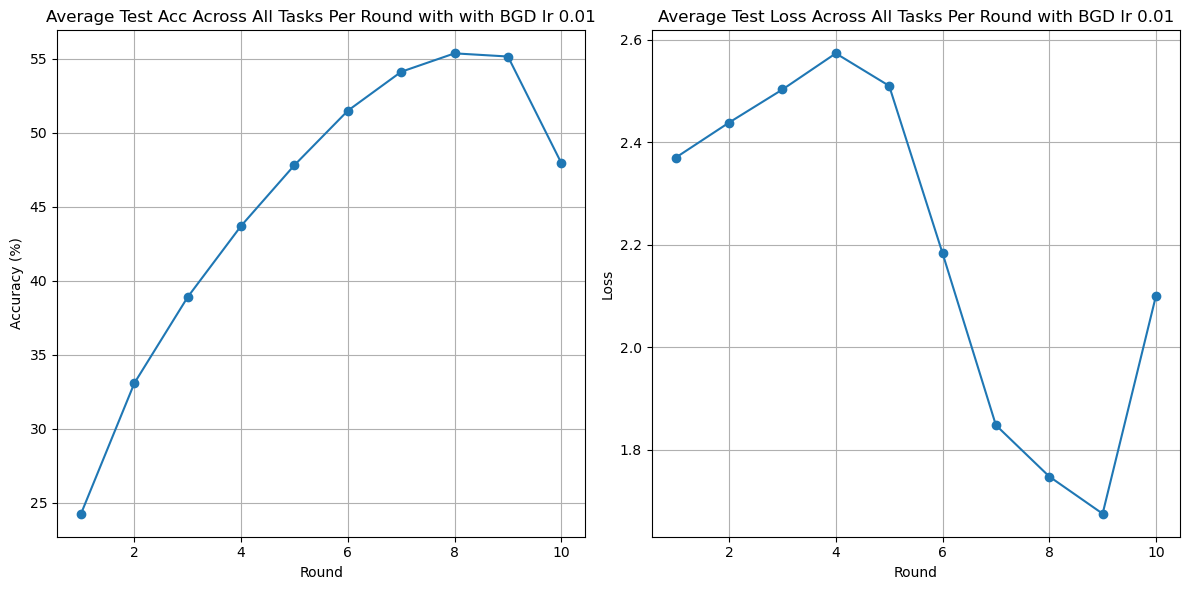

In [3]:


lr = 0.01
optim = 'BGD'

avg_accuracies = [24.246, 33.079, 38.901, 43.708, 47.818, 51.497, 54.127, 55.373, 55.159, 47.958]
avg_losses = [2.369765120678687, 2.4382211137704455, 2.502734151779662, 2.5732632816875283, 2.5098139525780194, 2.1832492287919116, 1.8477297599887166, 1.7475290822266025, 1.674952975448362, 2.100306634303135]


results_dir = '/home/gayam22139/BGD_FL/V_SGD_n_BGD_plots/check_plots'
get_accuracy_loss_plot(avg_accuracies, avg_losses, results_dir, lr = lr, optim= optim)

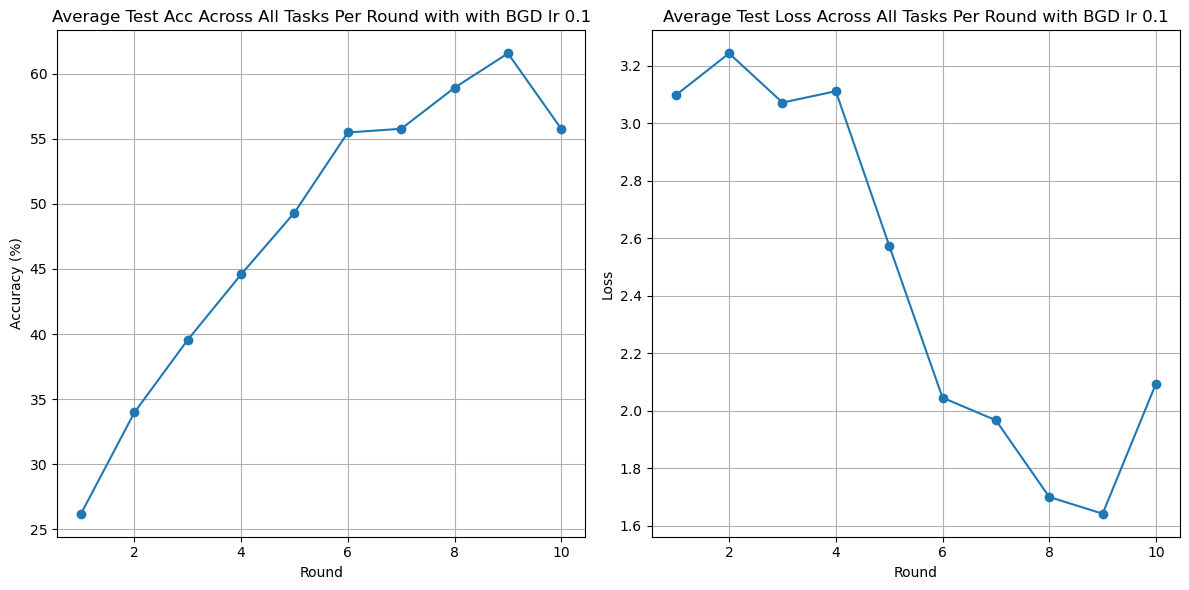

In [4]:


lr = 0.1
optim = 'BGD'

avg_accuracies = [26.205, 33.977, 39.556, 44.576, 49.323, 55.473, 55.755, 58.909, 61.548, 55.747]
avg_losses = [3.0967936092468946, 3.242371992822265, 3.0713733160426204, 3.1107463331916665, 2.574456286815561, 2.0456775603126265, 1.9672233284527696, 1.7007172037249056, 1.6425273135018572, 2.094546477478351]

results_dir = '/home/gayam22139/BGD_FL/V_SGD_n_BGD_plots/check_plots'
get_accuracy_loss_plot(avg_accuracies, avg_losses, results_dir, lr = lr, optim=optim)

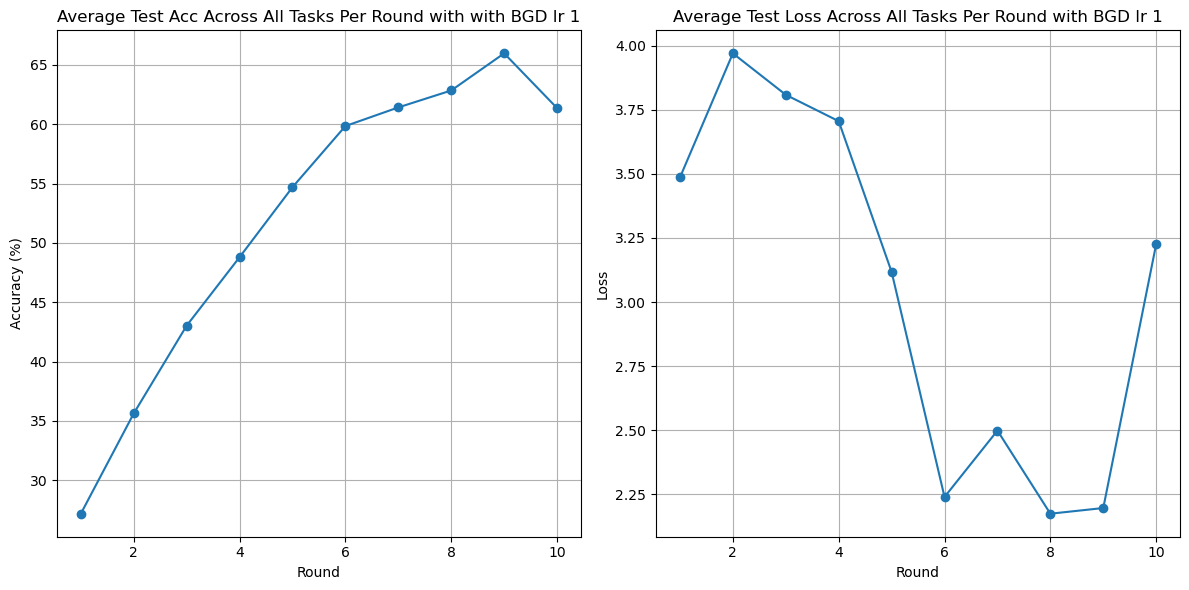

In [5]:


lr = 1
optim = 'BGD'

avg_accuracies = [27.184, 35.632, 43.028, 48.797, 54.693, 59.844, 61.414, 62.841, 65.969, 61.358]
avg_losses = [3.4859032155512835, 3.969713274268584, 3.8080579170110846, 3.7053260038210754, 3.117467837510997, 2.2400746675532406, 2.49899020158879, 2.174828485062252, 2.1969837222211797, 3.2260347454723033]

results_dir = '/home/gayam22139/BGD_FL/V_SGD_n_BGD_plots/check_plots'
get_accuracy_loss_plot(avg_accuracies, avg_losses, results_dir, lr = lr, optim = optim)

In [6]:
Avg Test Accuracies : [27.13, 27.521, 27.567, 28.085, 28.856, 27.578, 28.095, 27.584, 28.513, 21.499]
[2024-06-27 09:15:35 Info] Avg Test Losses : [2.224, 2.371, 2.429, 2.312, 2.233, 2.255, 2.333, 2.339, 2.337, 2.465]

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2183635172.py, line 2)

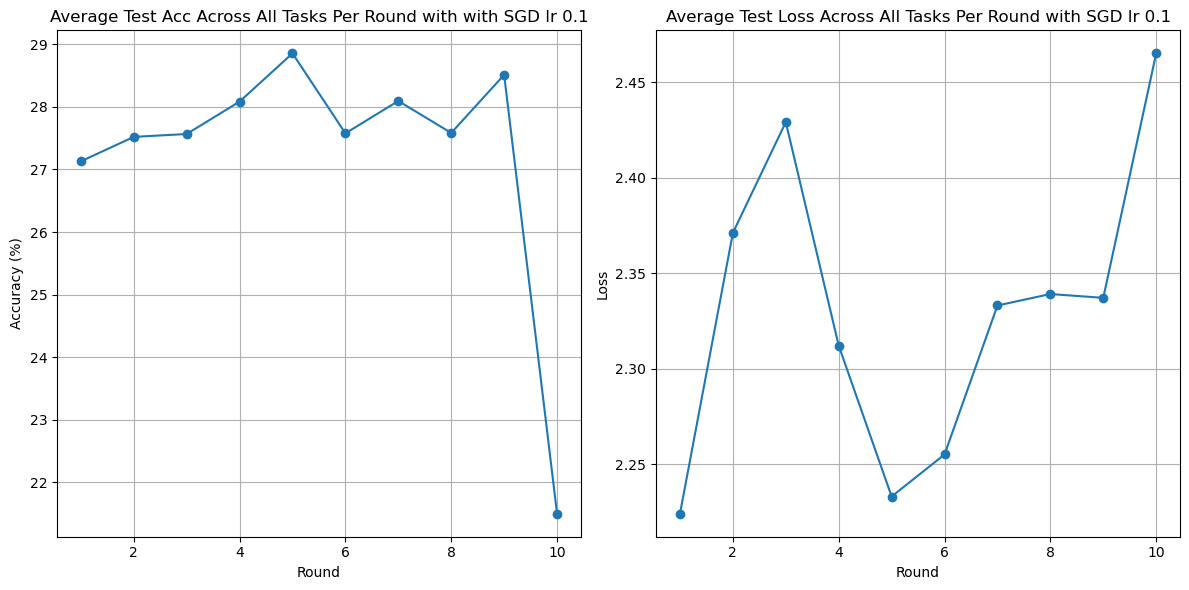

In [7]:
lr = 0.1
optim = 'SGD'


avg_accuracies =  [27.13, 27.521, 27.567, 28.085, 28.856, 27.578, 28.095, 27.584, 28.513, 21.499]
avg_losses =  [2.224, 2.371, 2.429, 2.312, 2.233, 2.255, 2.333, 2.339, 2.337, 2.465]

results_dir = '/home/gayam22139/BGD_FL/V_SGD_n_BGD_plots/check_plots'
get_accuracy_loss_plot(avg_accuracies, avg_losses, results_dir, optim = optim, lr = lr)

#### Plan for today 

+ Complete the baseline with SGD optimizer and get the plots and compare that of with BGD optimizer
+ Share the plots and ask for meeting to discuss proposed method

In [8]:
lst = [2.224, 2.371, 2.429, 2.312, 2.233, 2.255, 2.333, 2.339, 2.337, 2.465]



for round in range(10):
    print(round)
    for item in lst[:round+1]:
        print(f"round {round} item {item}")
    print("*"*100)

0
round 0 item 2.224
****************************************************************************************************
1
round 1 item 2.224
round 1 item 2.371
****************************************************************************************************
2
round 2 item 2.224
round 2 item 2.371
round 2 item 2.429
****************************************************************************************************
3
round 3 item 2.224
round 3 item 2.371
round 3 item 2.429
round 3 item 2.312
****************************************************************************************************
4
round 4 item 2.224
round 4 item 2.371
round 4 item 2.429
round 4 item 2.312
round 4 item 2.233
****************************************************************************************************
5
round 5 item 2.224
round 5 item 2.371
round 5 item 2.429
round 5 item 2.312
round 5 item 2.233
round 5 item 2.255
************************************************************************************

In [4]:
[round for round in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
import os
import matplotlib.pyplot as plt

def get_accuracy_loss_plot(avg_test_accuracies, avg_test_losses, task_wise_accuracies, results_dir, optimizer, lr):
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    plt.figure(figsize=(14, 6))

    # Plot average test accuracies
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(avg_test_accuracies) + 1), avg_test_accuracies, marker='o', linestyle='-', label='Avg Acc')

    # Plot task-wise accuracies with lines
    for task_no in range(len(task_wise_accuracies[-1])):
        task_accuracies = [task_wise_accuracies[round_no][task_no] if task_no < len(task_wise_accuracies[round_no]) else None for round_no in range(len(task_wise_accuracies))]
        task_accuracies = [acc for acc in task_accuracies if acc is not None]
        plt.plot(range(1, len(task_accuracies) + 1), task_accuracies, marker='x', linestyle='--', label=f'Task {task_no + 1} Acc', color=f'C{task_no}')

    plt.title(f'Average Test Acc Across All Tasks Per Round with {optimizer} lr={lr}')
    plt.xlabel('Round')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)

    # Plot average test losses
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(avg_test_losses) + 1), avg_test_losses, marker='o', linestyle='-', label='Avg Loss')
    plt.title(f'Average Test Loss Across All Tasks Per Round with {optimizer} lr={lr}')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    
    plt.savefig(os.path.join(results_dir, 'accuracy_loss_plot.png'))
    plt.close()

# Example usage with dummy values
avg_test_accuracies = [60, 65, 70, 75, 80, 85, 87, 88, 89, 90]
avg_test_losses = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45]
task_wise_accuracies = [
    [60],
    [65, 66],
    [70, 71, 72],
    [75, 76, 77, 78],
    [80, 81, 82, 83, 84],
    [85, 86, 87, 88, 89, 90],
    [87, 88, 89, 90, 91, 92, 93],
    [88, 89, 90, 91, 92, 93, 94, 95],
    [89, 90, 91, 92, 93, 94, 95, 96, 97],
    [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
]
results_dir = './results'
optimizer = 'SGD'
lr = 0.01

get_accuracy_loss_plot(avg_test_accuracies, avg_test_losses, task_wise_accuracies, results_dir, optimizer, lr)


In [15]:
import os
import matplotlib.pyplot as plt

def get_accuracy_loss_plot(avg_test_accuracies, avg_test_losses, task_wise_accuracies, results_dir, optimizer, lr):
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    plt.figure(figsize=(14, 6))

    # Plot average test accuracies
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(avg_test_accuracies) + 1), avg_test_accuracies, marker='o', linestyle='-', label='Avg Acc')

    # Plot task-wise accuracies with lines
    for task_no in range(len(task_wise_accuracies[-1])):
        task_accuracies = [task_wise_accuracies[round_no][task_no] if task_no < len(task_wise_accuracies[round_no]) else None for round_no in range(len(task_wise_accuracies))]
        task_accuracies = [acc for acc in task_accuracies if acc is not None]
        plt.plot(range(1, len(task_accuracies) + 1), task_accuracies, marker='x', linestyle='--', label=f'Task {task_no + 1} Acc')

    plt.title(f'Average Test Acc Across All Tasks Per Round with {optimizer} lr={lr}')
    plt.xlabel('Round')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)

    # Plot average test losses
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(avg_test_losses) + 1), avg_test_losses, marker='o', linestyle='-', label='Avg Loss')
    plt.title(f'Average Test Loss Across All Tasks Per Round with {optimizer} lr={lr}')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    
    plt.savefig(os.path.join(results_dir, 'accuracy_loss_plot.png'))
    plt.close()

# Example usage with dummy values
avg_test_accuracies = [60, 65, 70, 75, 80, 85, 87, 88, 89, 90]
avg_test_losses = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45]
task_wise_accuracies = [
    [60],
    [65, 66],
    [70, 71, 72],
    [75, 76, 77, 78],
    [80, 81, 82, 83, 84],
    [85, 86, 87, 88, 89, 90],
    [87, 88, 89, 90, 91, 92, 93],
    [88, 89, 90, 91, 92, 93, 94, 95],
    [89, 90, 91, 92, 93, 94, 95, 96, 97],
    [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
]
results_dir = './results'
optimizer = 'SGD'
lr = 0.01

get_accuracy_loss_plot(avg_test_accuracies, avg_test_losses, task_wise_accuracies, results_dir, optimizer, lr)


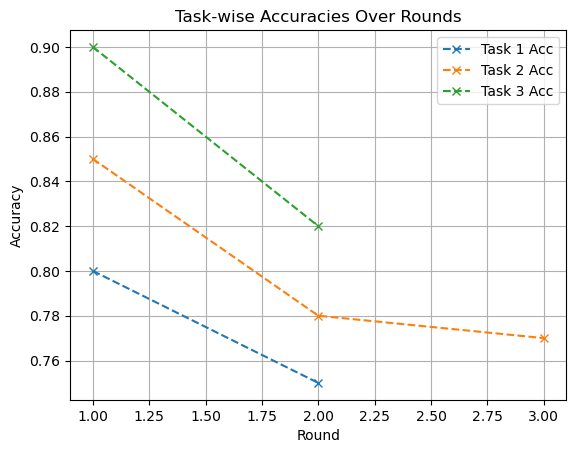

In [16]:
import matplotlib.pyplot as plt

# Example task-wise accuracies (replace with your actual data)
task_wise_accuracies = [[0.8, 0.75], [0.85, 0.78, 0.77], [0.9, 0.82]]

for task_no in range(len(task_wise_accuracies)):
    task_accuracies = task_wise_accuracies[task_no]
    plt.plot(range(1, len(task_accuracies) + 1), task_accuracies, marker='x', linestyle='--', label=f'Task {task_no + 1} Acc')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Task-wise Accuracies Over Rounds')
plt.legend()
plt.grid(True)
plt.show()


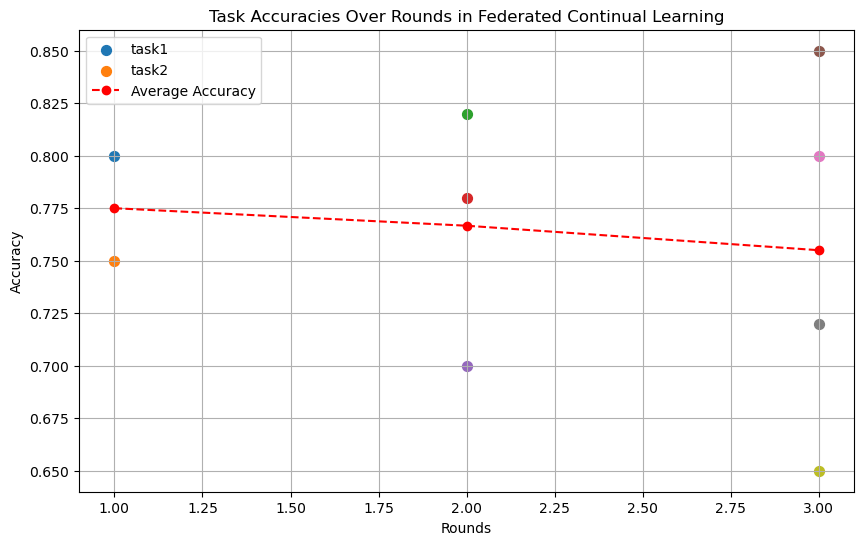

In [17]:
import matplotlib.pyplot as plt

# Sample accuracy data
accuracy_data = {
    1: {'task1': 0.8, 'task2': 0.75},
    2: {'task1': 0.82, 'task2': 0.78, 'task3': 0.7},
    3: {'task1': 0.85, 'task2': 0.8, 'task3': 0.72, 'task4': 0.65},
    # more rounds...
}

# Extract rounds
rounds = list(accuracy_data.keys())

# Initialize plot
plt.figure(figsize=(10, 6))

# Plot each task's accuracy over rounds
for round_num in rounds:
    for task, accuracy in accuracy_data[round_num].items():
        plt.scatter(round_num, accuracy, label=task if round_num == 1 else "", s=50)  # label only first occurrence

# Optional: Plot average accuracy
average_accuracies = [sum(tasks.values()) / len(tasks) for tasks in accuracy_data.values()]
plt.plot(rounds, average_accuracies, label='Average Accuracy', linestyle='--', marker='o', color='red')

# Plot settings
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Task Accuracies Over Rounds in Federated Continual Learning')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import os



if not os.path.exists('all_experiments_results'):
    os.makedirs('all_experiments_results')

In [2]:
!pwd

/home/gayam22139/BGD_FL/V_SGD_n_BGD_plots


In [4]:
results_dir = 'my_exp_1'

In [5]:
with open(f'all_experiments_results/{results_dir}.txt', 'w') as f:
    f.write("hi")

+ Ensuring data distribution is done 

In [ ]:
import torchvision.transforms as transforms
import torchvision
import torch
import numpy as np
import os
import codecs
from torch.distributions.categorical import Categorical
import torch.utils.data as data
from PIL import Image
import errno
import time


class Permutation(torch.utils.data.Dataset):
    """
    A dataset wrapper that permute the position of features
    """
    def __init__(self, dataset, permute_idx, target_offset):
        super(Permutation,self).__init__()
        self.dataset = dataset
        self.permute_idx = permute_idx
        self.target_offset = target_offset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, target = self.dataset[index]
        target = target + self.target_offset
        shape = img.size()
        img = img.view(-1)[self.permute_idx].view(shape)
        return img, target


def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """
  x_train = dataset[0] 

  num_items_per_client = int(len(x_train)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(x_train))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict 



"""all_datasets - full_dataset,n_clients - number of clients to which this data has to be distributed"""

"""Two ways of dividing the combined dataset
-First way - Divide each task dataset among clients(using desired strategy - IID/Non-IID) one-by-one
-Second way - Divide the combined dataset(treat all datapoints as a single dataset) among clients.(Here,the risk 
associated is there can be a scenario where samples belonging to a particular task
 do not go to a particular client)(Can this cause gradient shift?)"""

def generate_client_datasets(tasks_datasets,n_clients = 5,alpha = None):
    start_time = time.time()
    print("Client Indices Generation starts")

    n_tasks = len(tasks_datasets)
    
    clients_tasks_samples_indices = {client_id:[] for client_id in range(n_clients)}
    
    """client 0's tasks_samples_indices would be clients_tasks_samples_indices[0]
    
    Format of clients_tasks_samples_indices = {0:[[],[],[],[],....],1:[],2:[],....}
    
    """

    for task_id in range(n_tasks):
        dataset = tasks_datasets[task_id]

        dataset_x = [dataset[i][0] for i in range(len(dataset))]
        dataset_y = [dataset[i][1] for i in range(len(dataset))]    

        dataset = [dataset_x,dataset_y]

        client_dict = iid_partition(dataset,n_clients)

        for client_id in client_dict.keys():
            client_dict[client_id] = torch.tensor([len(dataset_x)*task_id+index for index in client_dict[client_id]])
            clients_tasks_samples_indices[client_id].append(client_dict[client_id])

    end_time = time.time()

    print("Clients Indices Generation ends")
    print("Client Indices Generation took",end_time-start_time,"seconds")

    return clients_tasks_samples_indices

def _create_probabilites_over_iterations(total_iters,total_datasets,beta):
    tasks_probs_over_iterations = [_create_task_probs(total_iters, total_datasets, task_id,beta=beta)[0] for task_id in range(total_datasets)]
        
    normalize_probs = torch.zeros_like(tasks_probs_over_iterations[0])
    for probs in tasks_probs_over_iterations:
        normalize_probs.add_(probs)
    for probs in tasks_probs_over_iterations:
        probs.div_(normalize_probs)
    tasks_probs_over_iterations = torch.cat(tasks_probs_over_iterations).view(-1, tasks_probs_over_iterations[0].shape[0])
    tasks_probs_over_iterations_lst = []
    for col in range(tasks_probs_over_iterations.shape[1]):
        tasks_probs_over_iterations_lst.append(tasks_probs_over_iterations[:, col])
        
    return tasks_probs_over_iterations_lst


class DatasetsLoaders:
    def __init__(self, dataset, batch_size=4, num_workers=4, pin_memory=True, **kwargs):
        # print("kwargs in datasetloaders - ",kwargs)
        self.dataset_name = dataset
        self.valid_loader = None
        self.num_workers = num_workers
        if self.num_workers is None:
            self.num_workers = 4

        self.random_erasing = kwargs.get("random_erasing", False)
        self.reduce_classes = kwargs.get("reduce_classes", None)
        self.permute = kwargs.get("permute", False)
        self.target_offset = kwargs.get("target_offset", 0)

        self.federated_learning = kwargs.get("fl",False)
        self.n_clients = kwargs.get("n_clients",5)

        pin_memory = pin_memory if torch.cuda.is_available() else False
        self.batch_size = batch_size
   
        if dataset == "CONTPERMUTEDPADDEDMNIST" or dataset == "CONTPERMUTEDMNIST":

            # if dataset == "CONTPERMUTEDPADDEDMNIST":
            #     transform = transforms.Compose(
            #         [transforms.Pad(2, fill=0, padding_mode='constant'),
            #         transforms.ToTensor(),
            #         transforms.Normalize(mean=(0.1000,), std=(0.2752,))])

            if dataset == "CONTPERMUTEDPADDEDMNIST":
                transform = transforms.Compose(
                    [transforms.Pad(2, fill=0, padding_mode='constant'),
                    transforms.ToTensor()])
            
            if dataset == "CONTPERMUTEDMNIST":
                transform = transforms.Compose(
                    [transforms.ToTensor()])

            # Original MNIST
            tasks_datasets = [torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)]
            total_len = len(tasks_datasets[0])
            test_loaders = [torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='./data', train=False,
                                                                                   download=True, transform=transform),
                                                        batch_size=self.batch_size, shuffle=False,
                                                        num_workers=self.num_workers, pin_memory=pin_memory)]
            self.num_of_permutations = len(kwargs.get("all_permutation"))
            all_permutation = kwargs.get("all_permutation", None)
            tasks_samples_indices = [torch.tensor(range(len(tasks_datasets[0])), dtype=torch.int32)]
            for p_idx in range(self.num_of_permutations):
                # Create permuation
                permutation = all_permutation[p_idx]

                # Add train set:
                tasks_datasets.append(Permutation(torchvision.datasets.MNIST(root='./data', train=True,
                                                                             download=True, transform=transform),
                                                  permutation, target_offset=0))

                if not self.federated_learning:
                    tasks_samples_indices.append(torch.tensor(range(total_len,
                                                                total_len + len(tasks_datasets[-1])
                                                                ), dtype=torch.int32))
                total_len += len(tasks_datasets[-1])
                # Add test set:
                test_set = Permutation(torchvision.datasets.MNIST(root='./data', train=False,
                                                                  download=True, transform=transform),
                                       permutation, self.target_offset)
                test_loaders.append(torch.utils.data.DataLoader(test_set, batch_size=self.batch_size,
                                                                shuffle=False, num_workers=self.num_workers,
                                                                pin_memory=pin_memory))
            self.test_loader = test_loaders
            # Concat datasets
            total_iters = kwargs.get("total_iters", None)

            assert total_iters is not None
            beta = kwargs.get("contpermuted_beta", 3)

            all_datasets = torch.utils.data.ConcatDataset(tasks_datasets)

            tasks_probs_over_iterations_lst = _create_probabilites_over_iterations(total_iters,self.num_of_permutations + 1,beta)
            
            self.tasks_probs_over_iterations = tasks_probs_over_iterations_lst

            #print(len(self.tasks_probs_over_iterations),self.tasks_probs_over_iterations[5800])

            # Create probabilities of tasks over iterations

            #We need to generate a client specific tasks_samples_indices object

            if self.federated_learning:
                round_end_iters = [_create_task_probs(total_iters,self.num_of_permutations+1,task_id,beta)[1]
                                    for task_id in range(self.num_of_permutations+1)]

                print(round_end_iters)

                clients_tasks_samples_indices = generate_client_datasets(tasks_datasets,self.n_clients)
                self.client_train_loaders = []
                for client_id in range(self.n_clients):
                    client_train_sampler = FederatedContinuousMultinomialSampler(data_source=all_datasets, samples_in_batch=self.batch_size,
                                                            tasks_samples_indices=clients_tasks_samples_indices[client_id],
                                                            tasks_probs_over_iterations=self.tasks_probs_over_iterations,
                                                            round_end_iter_lst=round_end_iters)
                    
                    train_loader = torch.utils.data.DataLoader(all_datasets,batch_size=self.batch_size,
                                                               num_workers=self.num_workers,sampler=client_train_sampler,pin_memory=pin_memory)

                    self.client_train_loaders.append(train_loader) 
            else:
                train_sampler = ContinuousMultinomialSampler(data_source=all_datasets, samples_in_batch=self.batch_size,
                                                            tasks_samples_indices=tasks_samples_indices,
                                                            tasks_probs_over_iterations=
                                                                self.tasks_probs_over_iterations,
                                                            num_of_batches=kwargs.get("iterations_per_virtual_epc", 1))
                
                self.train_loader = torch.utils.data.DataLoader(all_datasets, batch_size=self.batch_size,
                                                            num_workers=self.num_workers, sampler=train_sampler, pin_memory=pin_memory)
                

         
class ContinuousMultinomialSampler(torch.utils.data.Sampler):
    r"""Samples elements randomly. If without replacement, then sample from a shuffled dataset.
    If with replacement, then user can specify ``num_samples`` to draw.
    self.tasks_probs_over_iterations is the probabilities of tasks over iterations.
    self.samples_distribution_over_time is the actual distribution of samples over iterations
                                            (the result of sampling from self.tasks_probs_over_iterations).
    Arguments:
        data_source (Dataset): dataset to sample from
        num_samples (int): number of samples to draw, default=len(dataset)
        replacement (bool): samples are drawn with replacement if ``True``, default=False
    """

    def __init__(self, data_source, samples_in_batch=128, num_of_batches=69, tasks_samples_indices=None,
                 tasks_probs_over_iterations=None):
        self.data_source = data_source
        assert tasks_samples_indices is not None, "Must provide tasks_samples_indices - a list of tensors," \
                                                  "each item in the list corrosponds to a task, each item of the " \
                                                  "tensor corrosponds to index of sample of this task"
        self.tasks_samples_indices = tasks_samples_indices
        self.num_of_tasks = len(self.tasks_samples_indices)
        assert tasks_probs_over_iterations is not None, "Must provide tasks_probs_over_iterations - a list of " \
                                                         "probs per iteration"
        assert all([isinstance(probs, torch.Tensor) and len(probs) == self.num_of_tasks for
                    probs in tasks_probs_over_iterations]), "All probs must be tensors of len" \
                                                              + str(self.num_of_tasks) + ", first tensor type is " \
                                                              + str(type(tasks_probs_over_iterations[0])) + ", and " \
                                                              " len is " + str(len(tasks_probs_over_iterations[0]))
        self.tasks_probs_over_iterations = tasks_probs_over_iterations
        self.current_iteration = 0

        self.samples_in_batch = samples_in_batch
        self.num_of_batches = num_of_batches

        # Create the samples_distribution_over_time
        self.samples_distribution_over_time = [[] for _ in range(self.num_of_tasks)]
        self.iter_indices_per_iteration = []

        if not isinstance(self.samples_in_batch, int) or self.samples_in_batch <= 0:
            raise ValueError("num_samples should be a positive integeral "
                             "value, but got num_samples={}".format(self.samples_in_batch))
    
    def generate_iters_indices(self, num_of_iters):
        from_iter = len(self.iter_indices_per_iteration)
        for iter_num in range(from_iter, from_iter+num_of_iters):

            # Get random number of samples per task (according to iteration distribution)
            tsks = Categorical(probs=self.tasks_probs_over_iterations[iter_num]).sample(torch.Size([self.samples_in_batch]))
            # Generate samples indices for iter_num
            iter_indices = torch.zeros(0, dtype=torch.int32)
            for task_idx in range(self.num_of_tasks):
                if self.tasks_probs_over_iterations[iter_num][task_idx] > 0:
                    num_samples_from_task = (tsks == task_idx).sum().item()
                    self.samples_distribution_over_time[task_idx].append(num_samples_from_task)
                    # Randomize indices for each task (to allow creation of random task batch)
                    tasks_inner_permute = np.random.permutation(len(self.tasks_samples_indices[task_idx]))
                    rand_indices_of_task = tasks_inner_permute[:num_samples_from_task]
                    iter_indices = torch.cat([iter_indices, self.tasks_samples_indices[task_idx][rand_indices_of_task]])
                else:
                    self.samples_distribution_over_time[task_idx].append(0)
            self.iter_indices_per_iteration.append(iter_indices.tolist())

    def __iter__(self):
        self.generate_iters_indices(self.num_of_batches)
        self.current_iteration += self.num_of_batches
        return iter([item for sublist in self.iter_indices_per_iteration[self.current_iteration - self.num_of_batches:self.current_iteration] for item in sublist])

    def __len__(self):
        return len(self.samples_in_batch)


class FederatedContinuousMultinomialSampler(torch.utils.data.Sampler):
    r"""Samples elements randomly. If without replacement, then sample from a shuffled dataset.
    If with replacement, then user can specify ``num_samples`` to draw.
    self.tasks_probs_over_iterations is the probabilities of tasks over iterations.
    self.samples_distribution_over_time is the actual distribution of samples over iterations
                                            (the result of sampling from self.tasks_probs_over_iterations).
    Arguments:
        data_source (Dataset): dataset to sample from
        num_samples (int): number of samples to draw, default=len(dataset)
        replacement (bool): samples are drawn with replacement if ``True``, default=False
    """

    def __init__(self, data_source,round_end_iter_lst, samples_in_batch=128, tasks_samples_indices=None,
                 tasks_probs_over_iterations=None):
        self.data_source = data_source
        assert tasks_samples_indices is not None, "Must provide tasks_samples_indices - a list of tensors," \
                                                  "each item in the list corrosponds to a task, each item of the " \
                                                  "tensor corrosponds to index of sample of this task"
        self.tasks_samples_indices = tasks_samples_indices
        self.num_of_tasks = len(self.tasks_samples_indices)
        assert tasks_probs_over_iterations is not None, "Must provide tasks_probs_over_iterations - a list of " \
                                                         "probs per iteration"
        assert all([isinstance(probs, torch.Tensor) and len(probs) == self.num_of_tasks for
                    probs in tasks_probs_over_iterations]), "All probs must be tensors of len" \
                                                              + str(self.num_of_tasks) + ", first tensor type is " \
                                                              + str(type(tasks_probs_over_iterations[0])) + ", and " \
                                                              " len is " + str(len(tasks_probs_over_iterations[0]))
        self.tasks_probs_over_iterations = tasks_probs_over_iterations
        self.current_iteration = 0

        self.samples_in_batch = samples_in_batch
        self.round_end_iter_lst = round_end_iter_lst

        self.from_iter = 0
        self.to_iter_idx = 0

        self.current_round_start_iter = 0
        self.current_round_end_iter = self.round_end_iter_lst[self.to_iter_idx]

        # Create the samples_distribution_over_time
        self.samples_distribution_over_time = [[] for _ in range(self.num_of_tasks)]
        self.iter_indices_per_iteration = []

        if not isinstance(self.samples_in_batch, int) or self.samples_in_batch <= 0:
            raise ValueError("num_samples should be a positive integeral "
                             "value, but got num_samples={}".format(self.samples_in_batch))
    
    def generate_iters_indices(self, from_iter, to_iter):
        # from_iter = len(self.iter_indices_per_iteration)
        for iter_num in range(from_iter, to_iter):

            # Get random number of samples per task (according to iteration distribution)
            tsks = Categorical(probs=self.tasks_probs_over_iterations[iter_num]).sample(torch.Size([self.samples_in_batch]))
            # Generate samples indices for iter_num
            iter_indices = torch.zeros(0, dtype=torch.int32)
            for task_idx in range(self.num_of_tasks):
                if self.tasks_probs_over_iterations[iter_num][task_idx] > 0:
                    num_samples_from_task = (tsks == task_idx).sum().item()
                    self.samples_distribution_over_time[task_idx].append(num_samples_from_task)
                    # Randomize indices for each task (to allow creation of random task batch)
                    tasks_inner_permute = np.random.permutation(len(self.tasks_samples_indices[task_idx]))
                    rand_indices_of_task = tasks_inner_permute[:num_samples_from_task]
                    iter_indices = torch.cat([iter_indices, self.tasks_samples_indices[task_idx][rand_indices_of_task]])
                else:
                    self.samples_distribution_over_time[task_idx].append(0)
            self.iter_indices_per_iteration.append(iter_indices.tolist())

    def __iter__(self):
        self.generate_iters_indices(self.from_iter,self.round_end_iter_lst[self.to_iter_idx])

        self.current_round_start_iter = self.from_iter
        self.current_round_end_iter = self.round_end_iter_lst[self.to_iter_idx]

        self.from_iter = self.round_end_iter_lst[self.to_iter_idx]
        self.to_iter_idx+=1

        self.current_iteration = self.from_iter

        return iter([item for sublist in 
                     self.iter_indices_per_iteration[self.current_round_start_iter:self.current_round_end_iter] for item in sublist])

    def __len__(self):
        return (self.current_round_end_iter - self.current_round_start_iter)*(self.samples_in_batch)


def _get_linear_line(start, end, direction="up"):
    if direction == "up":
        return torch.FloatTensor([(i - start)/(end-start) for i in range(start, end)])
    return torch.FloatTensor([1 - ((i - start) / (end - start)) for i in range(start, end)])


def _create_task_probs(iters, tasks, task_id, beta=3):
    if beta <= 1:
        peak_start = int((task_id/tasks)*iters)
        peak_end = int(((task_id + 1) / tasks)*iters)
        start = peak_start
        end = peak_end
    else:
        start = max(int(((beta*task_id - 1)*iters)/(beta*tasks)), 0)
        peak_start = int(((beta*task_id + 1)*iters)/(beta*tasks))
        peak_end = int(((beta * task_id + (beta - 1)) * iters) / (beta * tasks))
        end = min(int(((beta * task_id + (beta + 1)) * iters) / (beta * tasks)), iters)

    #This is a probability dist for each task across iterations
    probs = torch.zeros(iters, dtype=torch.float)

    if task_id == 0:
        probs[start:peak_start].add_(1)
    else:
        probs[start:peak_start] = _get_linear_line(start, peak_start, direction="up")
    probs[peak_start:peak_end].add_(1)
    if task_id == tasks - 1:
        probs[peak_end:end].add_(1)
    else:
        probs[peak_end:end] = _get_linear_line(peak_end, end, direction="down")
    
    # with open('probs.txt','w') as f:
    #     f.write(str(probs.numpy().tolist()))

    return probs,end


###########################################################################
# Callable datasets
###########################################################################

#Customizing below method to include federated learning setting as we
#Same as the above method,only thing being padded has been removed and image size would be 28x28 only.
def ds_cont_permuted_mnist(**kwargs):
    """
    Continuous Permuted MNIST dataset
    Notice that this dataloader is aware to the epoch number, therefore if the training is loaded from a checkpoint
        adjustments might be needed. 
    Access dataset.tasks_probs_over_iterations to see the tasks probabilities for each iteration.
    :param num_epochs: Number of epochs for the training (since it builds distribution over iterations,
                            it needs this information in advance)
    :param iterations_per_virtual_epc: In continuous task-agnostic learning, the notion of epoch does not exists,
                                        since we cannot define 'passing over the whole dataset'. Therefore,
                                        we define "iterations_per_virtual_epc" -
                                        how many iterations consist a single epoch.
    :param contpermuted_beta: The proportion in which the tasks overlap. 4 means that 1/4 of a task duration will
                                consist of data from previous/next task. Larger values means less overlapping.
    :param permutations: The permutations which will be used (first task is always the original MNIST).
    :param batch_size: Batch size.
    :param num_workers: Num workers.
    :return: A tuple of (train_loaders, test_loaders). train_loaders is a list of 1 data loader - it loads the
                permuted MNIST dataset continuously as described in the paper. test_loaders is a list of 1+permutations
                data loaders, one for each dataset.

    """
    dataset = [DatasetsLoaders("CONTPERMUTEDMNIST", batch_size=kwargs.get("batch_size", 128),
                               num_workers=kwargs.get("num_workers", 1),
                               total_iters=(kwargs.get("num_epochs")*kwargs.get("iterations_per_virtual_epc")),
                               contpermuted_beta=kwargs.get("contpermuted_beta"),
                               iterations_per_virtual_epc=kwargs.get("iterations_per_virtual_epc"),
                               all_permutation=kwargs.get("permutations", []),fl=kwargs.get("federated_learning",False),n_clients=kwargs.get("n_clients",5))]
    
    test_loaders = [tloader for ds in dataset for tloader in ds.test_loader]
    
    if kwargs.get("federated_learning",False):
        train_loaders = dataset[0].client_train_loaders
    else:
        train_loaders = [ds.train_loader for ds in dataset]

    return train_loaders, test_loaders



In [ ]:
dataset = DatasetsLoaders("CONTPERMUTEDMNIST", batch_size=128,
                               num_workers=1,
                               total_iters=100*469,
                               contpermuted_beta=4,
                               iterations_per_virtual_epc=469,
                               all_permutation=all_permutation)

In [1]:
#### Create probabilities of tasks over iterations : Analysis of beta 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch


In [2]:

iters= 46900
tasks= 10


def _get_linear_line(start, end, direction="up"):
    if direction == "up":
        return torch.FloatTensor([(i - start)/(end-start) for i in range(start, end)])
    return torch.FloatTensor([1 - ((i - start) / (end - start)) for i in range(start, end)])


def _create_task_probs(iters, tasks, task_id, beta=3):
    if beta <= 1:
        peak_start = int((task_id/tasks)*iters)
        peak_end = int(((task_id + 1) / tasks)*iters)
        start = peak_start
        end = peak_end
    else:
        start = max(int(((beta*task_id - 1)*iters)/(beta*tasks)), 0)
        peak_start = int(((beta*task_id + 1)*iters)/(beta*tasks))
        peak_end = int(((beta * task_id + (beta - 1)) * iters) / (beta * tasks))
        end = min(int(((beta * task_id + (beta + 1)) * iters) / (beta * tasks)), iters)

    #This is a probability dist for each task across iterations
    probs = torch.zeros(iters, dtype=torch.float)

    if task_id == 0:
        probs[start:peak_start].add_(1)
    else:
        probs[start:peak_start] = _get_linear_line(start, peak_start, direction="up")
    probs[peak_start:peak_end].add_(1)
    if task_id == tasks - 1:
        probs[peak_end:end].add_(1)
    else:
        probs[peak_end:end] = _get_linear_line(peak_end, end, direction="down")
  

    return probs, end



In [3]:

num_of_permutations = 9
round_end_iters = [_create_task_probs(469*100, num_of_permutations+1, task_id, beta = 4)[1] for task_id in range(num_of_permutations+1)]
round_end_iters



[5862, 10552, 15242, 19932, 24622, 29312, 34002, 38692, 43382, 46900]

In [4]:

import numpy as np

thelist = [0, 5862, 10552, 15242, 19932, 24622, 29312, 34002, 38692, 43382, 46900]
result = np.concatenate([np.linspace(start, stop, 5, endpoint=True) for start, stop in zip(thelist[:-1], thelist[1:])])
result = np.append(result, thelist[-1])
result[1:], len(result[1:])


(array([ 1465.5,  2931. ,  4396.5,  5862. ,  5862. ,  7034.5,  8207. ,
         9379.5, 10552. , 10552. , 11724.5, 12897. , 14069.5, 15242. ,
        15242. , 16414.5, 17587. , 18759.5, 19932. , 19932. , 21104.5,
        22277. , 23449.5, 24622. , 24622. , 25794.5, 26967. , 28139.5,
        29312. , 29312. , 30484.5, 31657. , 32829.5, 34002. , 34002. ,
        35174.5, 36347. , 37519.5, 38692. , 38692. , 39864.5, 41037. ,
        42209.5, 43382. , 43382. , 44261.5, 45141. , 46020.5, 46900. ,
        46900. ]),
 50)

In [12]:
import numpy as np

thelist = [0, 5862, 10552, 15242, 19932, 24622, 29312, 34002, 38692, 43382, 46900]
result = np.concatenate([np.linspace(start, stop, 6, endpoint=True)[:-1] for start, stop in zip(thelist[:-1], thelist[1:])])
result = np.append(result, thelist[-1])
sliced_result = result[1:].astype(int)


sliced_result, len(sliced_result)


(array([ 1172,  2344,  3517,  4689,  5862,  6800,  7738,  8676,  9614,
        10552, 11490, 12428, 13366, 14304, 15242, 16180, 17118, 18056,
        18994, 19932, 20870, 21808, 22746, 23684, 24622, 25560, 26498,
        27436, 28374, 29312, 30250, 31188, 32126, 33064, 34002, 34940,
        35878, 36816, 37754, 38692, 39630, 40568, 41506, 42444, 43382,
        44085, 44789, 45492, 46196, 46900]),
 50)

In [23]:
task_end_iters = [0, 5862, 10552, 15242, 19932, 24622, 29312, 34002, 38692, 43382, 46900]

round_end_iters = np.concatenate([np.linspace(start, stop, 6, endpoint=True)[:-1] for start, stop in zip(task_end_iters[:-1], task_end_iters[1:])])
round_end_iters = np.append(round_end_iters, task_end_iters[-1])
round_end_iters = round_end_iters[1:].astype(int)

round_end_iters, len(round_end_iters)

(array([ 1172,  2344,  3517,  4689,  5862,  6800,  7738,  8676,  9614,
        10552, 11490, 12428, 13366, 14304, 15242, 16180, 17118, 18056,
        18994, 19932, 20870, 21808, 22746, 23684, 24622, 25560, 26498,
        27436, 28374, 29312, 30250, 31188, 32126, 33064, 34002, 34940,
        35878, 36816, 37754, 38692, 39630, 40568, 41506, 42444, 43382,
        44085, 44789, 45492, 46196, 46900]),
 50)

In [26]:
[[start, end, end-start] for start, end in zip(round_end_iters[:-1], round_end_iters[1:])]

[[1172, 2344, 1172],
 [2344, 3517, 1173],
 [3517, 4689, 1172],
 [4689, 5862, 1173],
 [5862, 6800, 938],
 [6800, 7738, 938],
 [7738, 8676, 938],
 [8676, 9614, 938],
 [9614, 10552, 938],
 [10552, 11490, 938],
 [11490, 12428, 938],
 [12428, 13366, 938],
 [13366, 14304, 938],
 [14304, 15242, 938],
 [15242, 16180, 938],
 [16180, 17118, 938],
 [17118, 18056, 938],
 [18056, 18994, 938],
 [18994, 19932, 938],
 [19932, 20870, 938],
 [20870, 21808, 938],
 [21808, 22746, 938],
 [22746, 23684, 938],
 [23684, 24622, 938],
 [24622, 25560, 938],
 [25560, 26498, 938],
 [26498, 27436, 938],
 [27436, 28374, 938],
 [28374, 29312, 938],
 [29312, 30250, 938],
 [30250, 31188, 938],
 [31188, 32126, 938],
 [32126, 33064, 938],
 [33064, 34002, 938],
 [34002, 34940, 938],
 [34940, 35878, 938],
 [35878, 36816, 938],
 [36816, 37754, 938],
 [37754, 38692, 938],
 [38692, 39630, 938],
 [39630, 40568, 938],
 [40568, 41506, 938],
 [41506, 42444, 938],
 [42444, 43382, 938],
 [43382, 44085, 703],
 [44085, 44789, 704],
 

In [21]:
lst = [1, 2]
lst.insert(0, 0)
lst 

[0, 1, 2]

In [14]:
total_rounds = 50

In [19]:
for round_no in range(len(round_end_iters)):
    if (round_no+1) % 5 == 0:
        print((round_no+1) // 5)
        print(round_end_iters[round_no])

1
5862
2
10552
3
15242
4
19932
5
24622
6
29312
7
34002
8
38692
9
43382
10
46900


In [ ]:
thelist[:-1], thelist[1:]

In [22]:
np.linspace(0, 10, 6)

array([ 0.,  2.,  4.,  6.,  8., 10.])

In [7]:

for start, stop in zip(thelist[:-1], thelist[1:]):
    print(start, stop)
    parts = np.linspace(start, stop, 6, endpoint=True)#[:-1]
    print(parts)
    

0 5862
[   0.  1172.4 2344.8 3517.2 4689.6 5862. ]
5862 10552
[ 5862.  6800.  7738.  8676.  9614. 10552.]
10552 15242
[10552. 11490. 12428. 13366. 14304. 15242.]
15242 19932
[15242. 16180. 17118. 18056. 18994. 19932.]
19932 24622
[19932. 20870. 21808. 22746. 23684. 24622.]
24622 29312
[24622. 25560. 26498. 27436. 28374. 29312.]
29312 34002
[29312. 30250. 31188. 32126. 33064. 34002.]
34002 38692
[34002. 34940. 35878. 36816. 37754. 38692.]
38692 43382
[38692. 39630. 40568. 41506. 42444. 43382.]
43382 46900
[43382.  44085.6 44789.2 45492.8 46196.4 46900. ]


In [ ]:
import numpy as np
num_rounds = 50
result = np.linspace(0, 46900, num_rounds + 1, endpoint=True, dtype=int)
result[1:],len(result[1:])


In [ ]:
[    0   938  1876  2814  3752  4690  5628  6566  7504  8442  9380 10318
 11256 12194 13132 14070 15008 15946 16884 17822 18760 19698 20636 21574
 22512 23450 24388 25326 26264 27202 28140 29078 30016 30954 31892 32830
 33768 34706 35644 36582 37520 38458 39396 40334 41272 42210 43148 44086
 45024 45962 46900] 

In [ ]:

def _get_linear_line(start, end, direction="up"):
    if direction == "up":
        return torch.FloatTensor([(i - start)/(end-start) for i in range(start, end)])
    return torch.FloatTensor([1 - ((i - start) / (end - start)) for i in range(start, end)])


def _create_task_probs(iters, tasks, task_id, beta=3):
    if beta <= 1:
        peak_start = int((task_id/tasks)*iters)
        peak_end = int(((task_id + 1) / tasks)*iters)
        start = peak_start
        end = peak_end
    else:
        start = max(int(((beta*task_id - 1)*iters)/(beta*tasks)), 0)
        peak_start = int(((beta*task_id + 1)*iters)/(beta*tasks))
        peak_end = int(((beta * task_id + (beta - 1)) * iters) / (beta * tasks))
        end = min(int(((beta * task_id + (beta + 1)) * iters) / (beta * tasks)), iters)

    #This is a probability dist for each task across iterations
    probs = torch.zeros(iters, dtype=torch.float)

    if task_id == 0:
        probs[start:peak_start].add_(1)
    else:
        probs[start:peak_start] = _get_linear_line(start, peak_start, direction="up")
    probs[peak_start:peak_end].add_(1)
    if task_id == tasks - 1:
        probs[peak_end:end].add_(1)
    else:
        probs[peak_end:end] = _get_linear_line(peak_end, end, direction="down")
  

    return probs, end 

In [ ]:

num_of_permutations = 9
round_end_iters = [_create_task_probs(469*100, num_of_permutations+1, task_id, beta = 4)[1] for task_id in range(num_of_permutations+1)]
round_end_iters 

In [ ]:
import numpy as np

thelist = [0, 5862, 10552, 15242, 19932, 24622, 29312, 34002, 38692, 43382, 46900]
result = np.concatenate([np.linspace(start, stop, 5, endpoint=True) for start, stop in zip(thelist[:-1], thelist[1:])])
result = np.append(result, thelist[-1])
result[1:], len(result[1:])


In [ ]:

import numpy as np

thelist = [0, 5862, 10552, 15242, 19932, 24622, 29312, 34002, 38692, 43382, 46900]
result = np.concatenate([np.linspace(start, stop, 6, endpoint=True)[:-1] for start, stop in zip(thelist[:-1], thelist[1:])])
result = np.append(result, thelist[-1])
sliced_result = result[1:]
length_sliced_result = len(sliced_result)

sliced_result, length_sliced_result

thelist[:-1], thelist[1:]
for start, stop in zip(thelist[:-1], thelist[1:]):
    print(start, stop)
    parts = np.linspace(start, stop, 5, endpoint=True)#[:-1]
    print(parts)


In [ ]:
import numpy as np
num_rounds = 50
result = np.linspace(0, 46900, num_rounds + 1, endpoint=True, dtype=int)
result[1:],len(result[1:])


In [ ]:
[    0   938  1876  2814  3752  4690  5628  6566  7504  8442  9380 10318
 11256 12194 13132 14070 15008 15946 16884 17822 18760 19698 20636 21574
 22512 23450 24388 25326 26264 27202 28140 29078 30016 30954 31892 32830
 33768 34706 35644 36582 37520 38458 39396 40334 41272 42210 43148 44086
 45024 45962 46900] 

In [17]:
rounds = 10
num_aggs_per_task = 1

test_loaders = [f'dataset {i}' for i in range(10)]


for round_no in range(rounds):
    task_no = (round_no ) // (num_aggs_per_task) # always be from 0 - 9 || 0-4 rounds (task_no 0) || 5-9 rounds (task_no 1)
    print(f'task no {task_no+1}')

task no 1
task no 2
task no 3
task no 4
task no 5
task no 6
task no 7
task no 8
task no 9
task no 10


In [12]:
rounds = 10
num_aggs_per_task = 1

test_loaders = [f'dataset {i}' for i in range(10)]


for round_no in range(rounds):
    task_no = (round_no ) #// (num_aggs_per_task) # always be from 0 - 9 || 0-4 rounds (task_no 0) || 5-9 rounds (task_no 1)
    print(f'task no {task_no+1}')

task no 1
task no 2
task no 3
task no 4
task no 5
task no 6
task no 7
task no 8
task no 9
task no 10


In [19]:
rounds = 50
num_aggs_per_task = 5

test_loaders = [f'dataset {i}' for i in range(10)]

for round_no in range(rounds):
    task_no = (round_no) // (num_aggs_per_task) # always be from 0 - 9 || 0-4 rounds (task_no 0) || 5-9 rounds (task_no 1)
    print(f'task no {task_no + 1}')

task no 1
task no 1
task no 1
task no 1
task no 1
task no 2
task no 2
task no 2
task no 2
task no 2
task no 3
task no 3
task no 3
task no 3
task no 3
task no 4
task no 4
task no 4
task no 4
task no 4
task no 5
task no 5
task no 5
task no 5
task no 5
task no 6
task no 6
task no 6
task no 6
task no 6
task no 7
task no 7
task no 7
task no 7
task no 7
task no 8
task no 8
task no 8
task no 8
task no 8
task no 9
task no 9
task no 9
task no 9
task no 9
task no 10
task no 10
task no 10
task no 10
task no 10
